# Code for Time-frequency Analysis of EEG data

##### Alexandra Ciulisova, Lydia Rambrand
Cognitive Neuroscience, Cognitive Science, Aarhus University 2025

## Pre-processing with ICA

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne
import os
import sklearn
import pandas as pd

In [75]:
# give path
path = Path("/work/own_experiments")
sample_data_raw_file = path / 'group3_own.vhdr' # change based on participant
raw = mne.io.read_raw_brainvision(sample_data_raw_file, eog = ["HEOG", "VEOG"])
raw.load_data()

Extracting parameters from /work/own_experiments/group3_own.vhdr...
Setting channel info structure...
Reading 0 ... 627359  =      0.000 ...   627.359 secs...


<RawBrainVision | group3_own.eeg, 32 x 627360 (627.4 s), ~153.2 MB, data loaded>

In [ ]:
# for playing with finding the bad channels
%matplotlib inline

raw = mne.io.read_raw_brainvision(sample_data_raw_file, eog = ["HEOG", "VEOG"])
raw.load_data()
raw.info["bads"] = ["O2", "T8", "Fp1", "Fp2", "TP10", "CP5"]
raw.pick(picks = ['eeg', 'stim'], exclude = 'bads')
raw.filter(l_freq = 0.1, h_freq = 40)
raw.set_eeg_reference("average", projection = True)
raw.apply_proj()
raw.plot(n_channels = 32, duration = 20, start = 200);

In [ ]:
# read the data again after identified bad channels
path = Path("/work/own_experiments")
sample_data_raw_file = path / 'group3_own.vhdr' # change based on participant
raw = mne.io.read_raw_brainvision(sample_data_raw_file, eog = ["HEOG", "VEOG"])
raw.load_data()

In [76]:
# pick only EEG
raw.pick_types(meg=False, eeg=True, stim=True, exclude=[])

# bad channels
raw.info['bads'] = ["O2", "T8", "Fp1", "Fp2", "TP10", "CP5"] # know the bad channels

# common average
raw.set_eeg_reference(ref_channels='average', ch_type='eeg')


# high-pass 
# ICA is sensitive to slow drifts, therefore we are here using a high high-pass filter! 
# Note however, that when applying the ICA, we will do it to data high-pass filtered at 0.1 Hz
# See https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA
raw_fit = raw.copy().filter(1, None)

# low-pass 
raw_fit = raw_fit.filter(None, 40)

# high and low-pass filtering for the data not used to fit the ICA
raw = raw.filter(0.1, None)

# low-pass 
raw = raw.filter(None, 40)

montage = mne.channels.make_standard_montage('standard_1020')
raw_fit.set_montage(montage, verbose=False)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


<RawBrainVision | group3_own.eeg, 30 x 627360 (627.4 s), ~143.6 MB, data loaded>

In [77]:
ica = mne.preprocessing.ICA(n_components = 0.95, random_state = 7, max_iter = 800).fit(raw_fit)

Fitting ICA to data using 24 channels (please be patient, this may take a while)
Selecting by explained variance: 15 components
Fitting ICA took 6.5s.


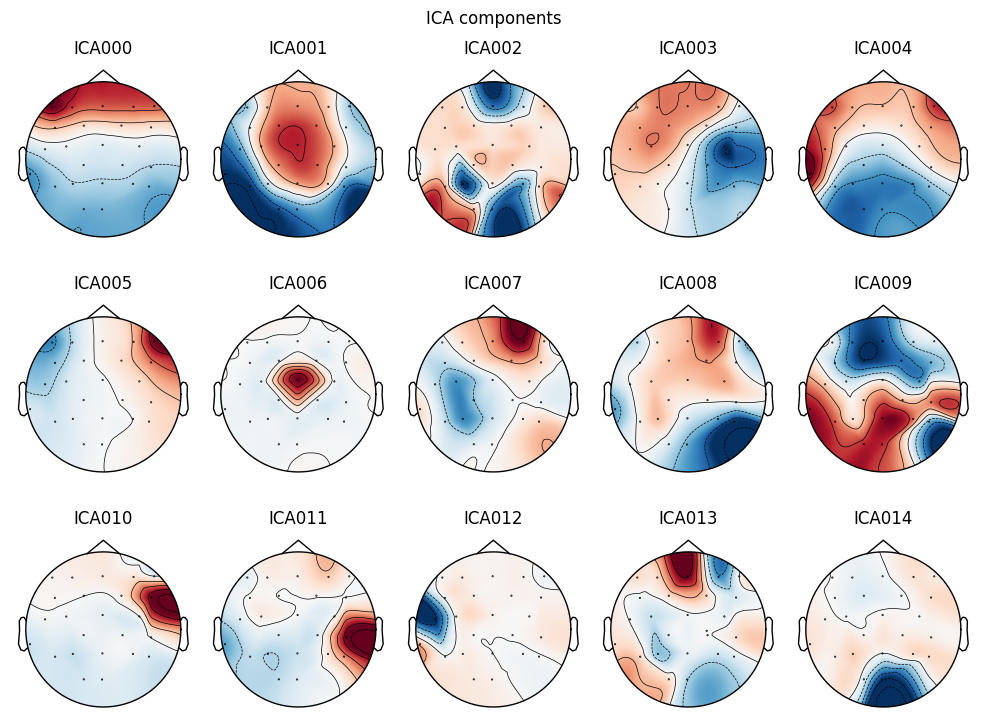

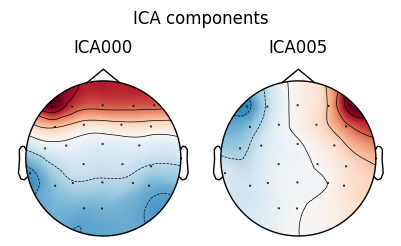

In [78]:
ica.plot_components();
ica.plot_sources(raw_fit);

In [79]:
ica.exclude = [0,5] # exclude the noisy channels
ica.apply(raw, exclude=ica.exclude) # exclude from the raw data, not raw_fit

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 24 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 24 PCA components


<RawBrainVision | group3_own.eeg, 30 x 627360 (627.4 s), ~143.6 MB, data loaded>

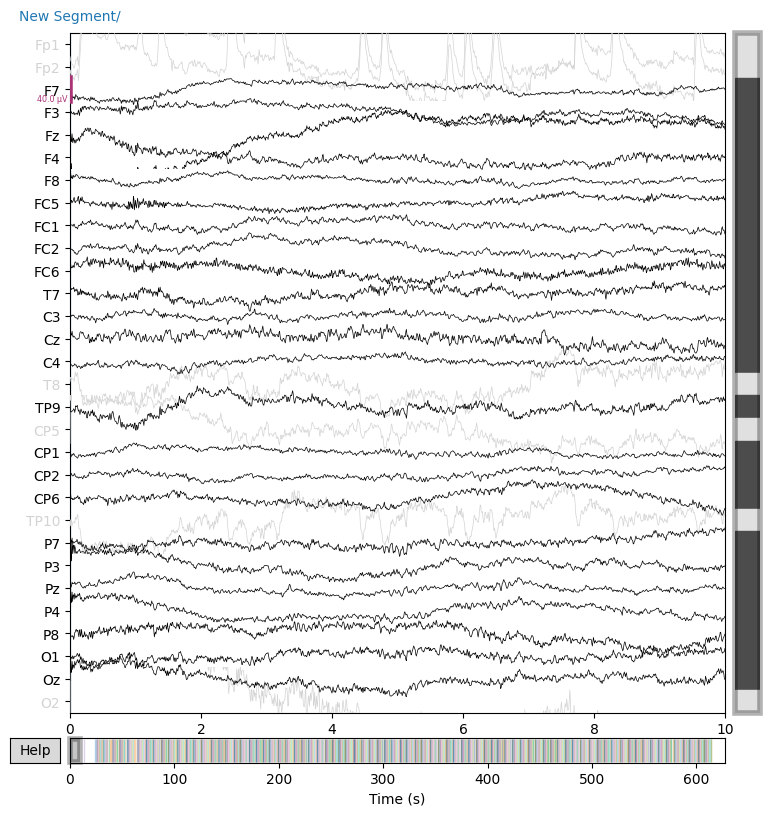

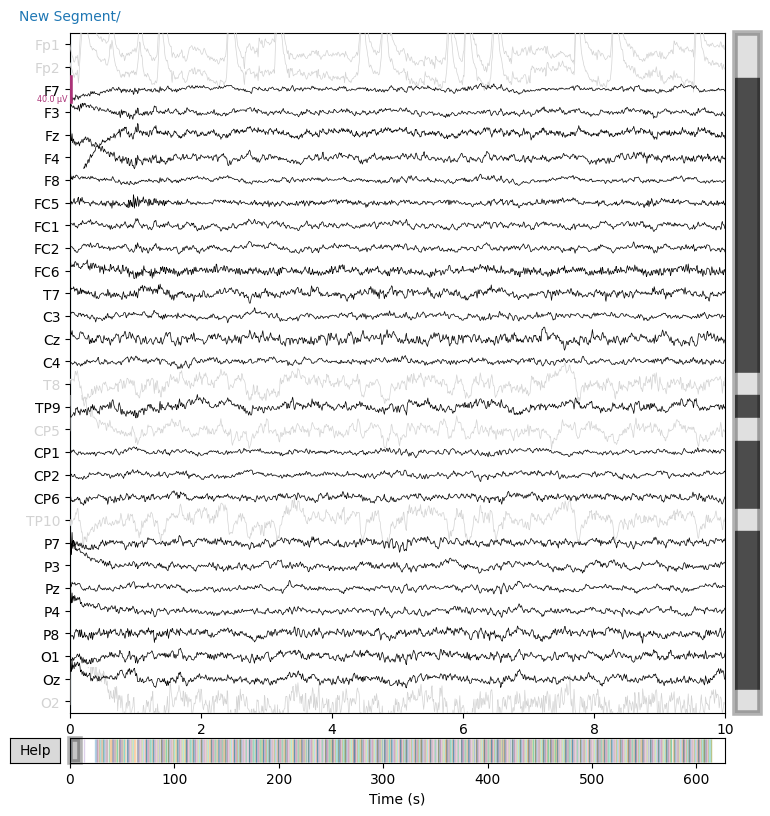

In [72]:
# plot the difference
raw.plot(n_channels=30, title='After ICA');

In [80]:
# set montage for raw so we can plot topography
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)

<RawBrainVision | group3_own.eeg, 30 x 627360 (627.4 s), ~143.6 MB, data loaded>

In [30]:
# export the pre-processed raw data
outpath = os.path.join(os.getcwd(), 'ICA_own')

if not os.path.exists(outpath):
    os.makedirs(outpath)

raw.save(os.path.join(outpath, 'raw-epo-ICA-2.fif'), overwrite=True) # make sure to change the name for participant

Overwriting existing file.
Writing /work/EEG/CogNeuro2025/EEG_LAB/ICA_own/epochs-epo-ICA-2.fif


/tmp/ipykernel_4802/134028978.py:8: RuntimeWarning: This filename (/work/EEG/CogNeuro2025/EEG_LAB/ICA_own/epochs-epo-ICA-2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(os.path.join(outpath, 'epochs-epo-ICA-2.fif'), overwrite=True)


Closing /work/EEG/CogNeuro2025/EEG_LAB/ICA_own/epochs-epo-ICA-2.fif
[done]


## Creating Epochs
#### normative contrast

In [38]:
# for reading the raw ICA data
input_path = os.path.join(os.getcwd(), 'ICA_own')
filename = "raw-epo-ICA.fif" # change for participant

raw = mne.io.read_raw_fif(os.path.join(input_path, filename), preload=True)
raw.load_data()

Opening raw data file /work/EEG/CogNeuro2025/EEG_LAB/ICA_own/raw-epo-ICA.fif...
    Range : 0 ... 627359 =      0.000 ...   627.359 secs
Ready.
Reading 0 ... 627359  =      0.000 ...   627.359 secs...


/tmp/ipykernel_848/813134072.py:4: RuntimeWarning: This filename (/work/EEG/CogNeuro2025/EEG_LAB/ICA_own/raw-epo-ICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(os.path.join(input_path, filename), preload=True)


In [40]:
# Set up an event_id-dictionary with the relevant event labels (our own contrast coding)

event_id = {'action/s_coherent/m_coherent': 1,
'sentence/s_coherent/m_coherent': 2,
'action/s_coherent/m_incoherent': 3,
'sentence/s_coherent/m_incoherent': 4,
'action/s_incoherent/m_coherent': 5,
'sentence/s_incoherent/m_coherent': 6,
'action/s_incoherent/m_incoherent': 7,
'sentence/s_incoherent/m_incoherent': 8,
'coherent_response': 11,
'incoherent_response': 12,
'segment1' : 10,
'segment2' : 20,
'segment3' : 30,
'segment4' : 40,
'segment5' : 50,
'segment6' : 60,
'segment7' : 70,
'fixation_after_response': 100, 
'fixation_before_response': 200
}

events, _ = mne.events_from_annotations(raw)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 30'), np.str_('Stimulus/S 40'), np.str_('Stimulus/S 50'), np.str_('Stimulus/S 60'), np.str_('Stimulus/S 70'), np.str_('Stimulus/S100'), np.str_('Stimulus/S200'), np.str_('Stimulus/S203'), np.str_('Stimulus/S204')]


/tmp/ipykernel_848/1396415372.py:1: RuntimeWarning: event 203 missing from event_id will be ignored
  mne.viz.plot_events(events, event_id = event_id);
/tmp/ipykernel_848/1396415372.py:1: RuntimeWarning: event 204 missing from event_id will be ignored
  mne.viz.plot_events(events, event_id = event_id);
/tmp/ipykernel_848/1396415372.py:1: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events, event_id = event_id);
/tmp/ipykernel_848/1396415372.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, event_id = event_id);


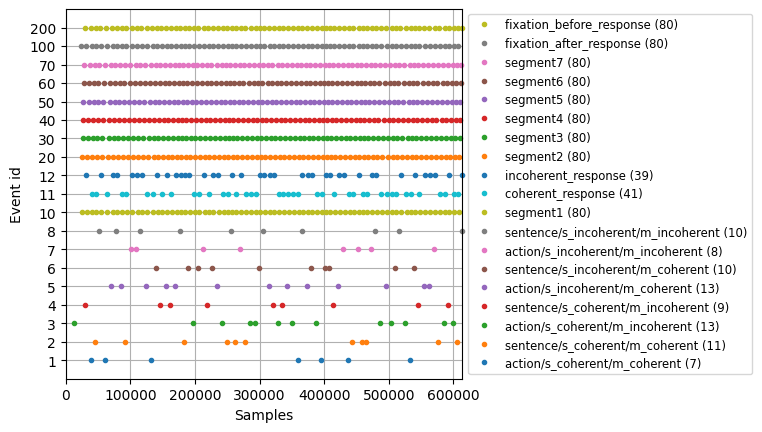

Not setting metadata
881 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 881 events and 1001 original time points ...
0 bad epochs dropped


<Epochs | 881 events (all good), -0.2 – 0.796 s (baseline -0.2 – 0 s), ~50.5 MB, data loaded,
 'action/s_coherent/m_coherent': 7
 'sentence/s_coherent/m_coherent': 11
 'action/s_coherent/m_incoherent': 13
 'sentence/s_coherent/m_incoherent': 9
 'action/s_incoherent/m_coherent': 13
 'sentence/s_incoherent/m_coherent': 10
 'action/s_incoherent/m_incoherent': 8
 'sentence/s_incoherent/m_incoherent': 10
 'coherent_response': 41
 'incoherent_response': 39
 and 9 more events ...>

In [41]:
# Visualising the epochs
mne.viz.plot_events(events, event_id = event_id);

picks = ["eeg"]
reject = {'eeg': 150e-6}
tmin, tmax = -0.2, 0.8
epochs = mne.Epochs(raw, events = events, event_id = event_id, tmin = tmin, tmax = tmax, baseline = (-0.2, 0), reject = reject, picks = picks)

epochs.load_data()
epochs.resample(sfreq = 250) # resample

In [23]:
# save the epochs

outpath = os.path.join(os.getcwd(), 'epochs')

if not os.path.exists(outpath):
    os.makedirs(outpath)

epochs.save(os.path.join(outpath, 'Own-experiment_group3_epochs-epo.fif'), overwrite=True)

Overwriting existing file.
Overwriting existing file.


#### subjective contrast (based on participants' answers)

In [42]:
## ,trial_number,response,trial_type,music_condition,stim_condition

df = pd.read_csv("/work/own_experiments/logfiles/group3/logfile_test.csv") # change for participant
df_values = 4 * df.iloc[:,2] + 1 * df.iloc[:,3] + 2 * df.iloc[:,4] + 1

In [43]:
#events, _ = mne.events_from_annotations(raw)
r_is = np.where(events[5:,2]<9)[0] + 5
subject_rating_events = events.copy()
subject_rating_events[r_is,2] = df_values.copy()

In [44]:
subject_rating_events[:,2]

array([99999,     3,   100,    10,    20,    30,    40,    50,    60,
          70,     8,   200,    12,   100,    10,    20,    30,    40,
          50,    60,    70,     1,   200,    11,   100,    10,    20,
          30,    40,    50,    60,    70,     6,   200,    11,   100,
          10,    20,    30,    40,    50,    60,    70,     8,   200,
         204,    12,   100,    10,    20,    30,    40,    50,    60,
          70,     1,   200,    11,   100,    10,    20,    30,    40,
          50,    60,    70,     1,   200,   204,    12,   100,    10,
          20,    30,    40,    50,    60,    70,     8,   200,    12,
         100,    10,    20,    30,    40,    50,    60,    70,     1,
         200,   203,    11,   100,    10,    20,    30,    40,    50,
          60,    70,     2,   200,   203,    11,   100,    10,    20,
          30,    40,    50,    60,    70,     7,   200,   204,    12,
         100,    10,    20,    30,    40,    50,    60,    70,     7,
         200,   204,

/tmp/ipykernel_848/2833807942.py:1: RuntimeWarning: event 203 missing from event_id will be ignored
  mne.viz.plot_events(subject_rating_events, event_id = event_id);
/tmp/ipykernel_848/2833807942.py:1: RuntimeWarning: event 204 missing from event_id will be ignored
  mne.viz.plot_events(subject_rating_events, event_id = event_id);
/tmp/ipykernel_848/2833807942.py:1: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(subject_rating_events, event_id = event_id);
/tmp/ipykernel_848/2833807942.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(subject_rating_events, event_id = event_id);


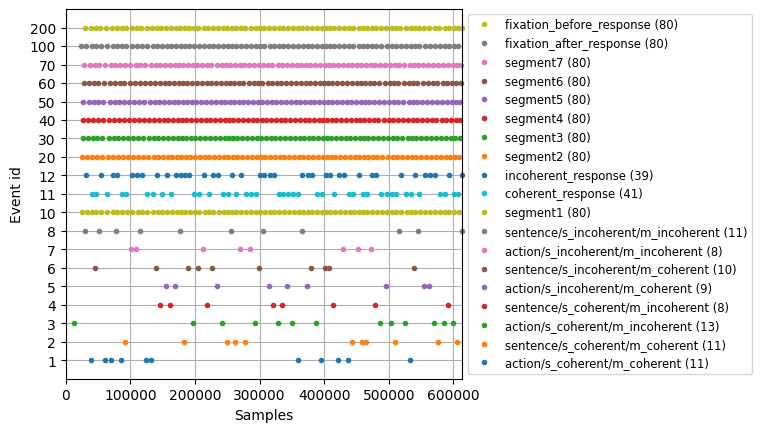

In [45]:
# visualise
mne.viz.plot_events(subject_rating_events, event_id = event_id);

In [46]:
# make the epochs
picks = ["eeg"]
reject = {'eeg': 150e-6}
tmin, tmax = -0.2, 0.8
subject_rating_epochs = mne.Epochs(raw, events = subject_rating_events, event_id = event_id, tmin = tmin, tmax = tmax, baseline = (-0.2, 0), reject = reject, picks = picks)

Not setting metadata
881 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [47]:
# resample
subject_rating_epochs.load_data()
subject_rating_epochs.resample(sfreq = 250)

Using data from preloaded Raw for 881 events and 1001 original time points ...
0 bad epochs dropped


<Epochs | 881 events (all good), -0.2 – 0.796 s (baseline -0.2 – 0 s), ~50.5 MB, data loaded,
 'action/s_coherent/m_coherent': 11
 'sentence/s_coherent/m_coherent': 11
 'action/s_coherent/m_incoherent': 13
 'sentence/s_coherent/m_incoherent': 8
 'action/s_incoherent/m_coherent': 9
 'sentence/s_incoherent/m_coherent': 10
 'action/s_incoherent/m_incoherent': 8
 'sentence/s_incoherent/m_incoherent': 11
 'coherent_response': 41
 'incoherent_response': 39
 and 9 more events ...>

In [48]:
# output
outpath = os.path.join(os.getcwd(), 'epochs')

if not os.path.exists(outpath):
    os.makedirs(outpath)

epochs.save(os.path.join(outpath, 'Own-experiment_group3_epochs_subject_rating-epo.fif'), overwrite=True)

Overwriting existing file.
Overwriting existing file.


## Time-Frequency analysis based on MNE
https://mne.tools/stable/auto_tutorials/stats-sensor-space/70_cluster_rmANOVA_time_freq.html

In [50]:
# read in the libraries (might be repetitions from beginning)
from mne.datasets import sample
from mne.stats import f_mway_rm, f_threshold_mway_rm, fdr_correction
import mne
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import mne
import os

In [51]:
# The Channel names for our ROIs
LA = ["F7", "F3", "FC5", "FC1"]
RA = ["F4", "FC6", "FC2", "F8"]
LP = ["P3", "P7", "CP1", "TP9"]
RP = ["P4", "CP2", "CP6", "P8"]

In [52]:
# Factor to down-sample the temporal dimension of the TFR computed by tfr_morlet
def tfr(epoch, stim, event_id):
    decim = 1
    freqs = np.arange(3, 45)  # define frequencies of interest
    n_cycles = freqs / freqs[0]
    zero_mean = True  # don't correct morlet wavelet to be of mean zero #LOOK INTO LATER
    # To have a true wavelet zero_mean should be True but here for illustration purposes it helps to spot the evoked response
    epochs_power = list()
    for condition in [epoch[k] for k in event_id]:
        this_tfr = condition.compute_tfr(
            "morlet",
            freqs,
            n_cycles=n_cycles,
            decim=decim,
            average=False,
            zero_mean=zero_mean,
            return_itc=False,
        )
        this_tfr.apply_baseline(mode="ratio", baseline=(-0.2, 0))  # change the baseline!!!!
        this_power = this_tfr.data[:, :, :, :]
        epochs_power.append(this_power)
    average_epochs_power = np.average(epochs_power, axis = 2)
    return average_epochs_power

In [53]:
# Setting up
def anova(epoch, average_epochs_power, effects):
    freqs = np.arange(3, 45)
    n_conditions = 4
    n_replications = epoch.events.shape[0] // n_conditions
    factor_levels = [2, 2]  # number of levels in each factor
    effects = effects
    n_freqs = len(freqs)
    decim = 1
    times = 1e3 * epoch.times[::decim] #instead of decim 2 we have 1 because we want to keep every sample in epochs
    n_times = len(times)
    
    def stat_fun(*args):
        return f_mway_rm(
            np.swapaxes(args, 1, 0),
            factor_levels=factor_levels,
            effects=effects,
            return_pvals=True,
        )[0]
    
    # The ANOVA returns a tuple f-values and p-values, we will pick the former.
    pthresh = 0.05  # set threshold rather to be 0.05
    f_thresh = f_threshold_mway_rm(n_replications, factor_levels, effects, pthresh)
    tail = 0  # both sided
    n_permutations = 800  # CHANGE TO LARGER AMOUNT IF RUNNING :))
    F_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(
        average_epochs_power,
        stat_fun=stat_fun,
        threshold=f_thresh,
        tail=tail,
        n_jobs=None,
        n_permutations=n_permutations,
        buffer_size=None,
        out_type="mask",
        seed=0,
    )

    print(cluster_p_values)
    return F_obs, clusters, cluster_p_values, h0
    

In [54]:
# Plotting
def plot_anova(epoch, F_obs, clusters, cluster_p_values, h0, stim, effects, ROI, participant_id, ROI_name):
    freqs = np.arange(3, 45)
    decim = 1
    times = 1e3 * epoch.times[::decim]
    good_clusters = np.where(cluster_p_values < 0.05)[0]
    F_obs_plot = np.full_like(F_obs, np.nan)
    for ii in good_clusters:
        F_obs_plot[clusters[ii]] = F_obs[clusters[ii]]

    fig, ax = plt.subplots(figsize=(6, 4), layout="constrained")
    for f_image, cmap in zip([F_obs, F_obs_plot], ["gray", "autumn"]):
        c = ax.imshow(
            f_image,
            cmap=cmap,
            aspect="auto",
            origin="lower",
            extent=[times[0], times[-1], freqs[0], freqs[-1]],
        )

    fig.colorbar(c, ax=ax)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(
        f'Time-locked response for {effects} of {stim} ({ROI_name})\n'
        "cluster-level corrected (p <= 0.05)"
    )

    plt.savefig(f'own_experiment_fig/{ROI_name}_{effects}_{stim}_{participant_id}.png')

In [77]:
# The master function

def analysis_anova(epoch, event_id, ROI, ROI_name, participant_id, stim, effects):
    #pick epochs
    epoch.pick(ROI)
    # do tfr and epochs power
    average_epochs_power = tfr(epoch, stim, event_id)
    # anova
    F_obs, clusters, cluster_p_values, h0 = anova(epoch, average_epochs_power, effects)
    # plotting
    plot_anova(epoch, F_obs, clusters, cluster_p_values, h0, stim, effects, ROI, participant_id, ROI_name)

## Significant Results
#### as inspiration for how to use the function

Reading /work/EEG/CogNeuro2025/EEG_LAB/epochs/Own-experiment_group3_epochs-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     796.00 ms
        0 CTF compensation matrices available
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated
Dropped 25 epochs: 17, 19, 20, 26, 27, 28, 30, 31, 32, 35, 36, 37, 39, 41, 60, 61, 64, 65, 66, 73, 76, 77, 78, 79, 80
Dropped 13 epochs: 9, 10, 13, 16, 17, 18, 19, 30, 32, 33, 37, 39, 40
Dropped 4 epochs: 3, 25, 29, 30
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
stat_fun(H1): min=2.6244894234545454e-13 max=85.66357145783739
Running initial clustering …
Found 10 clusters


  0%|          | Permuting : 0/799 [00:00<?,       ?it/s]

[0.74125 0.94625 0.99875 0.9975  0.97125 0.93375 0.9375  0.005   0.05625
 0.99375]


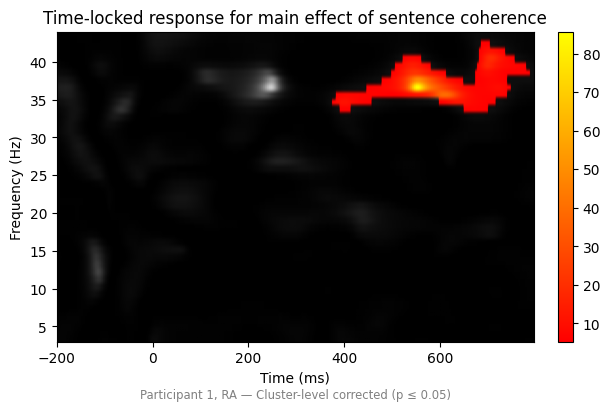

In [78]:
input_path = os.path.join(os.getcwd(), 'epochs')
filename = 'Own-experiment_group3_epochs-epo.fif'

epochs = mne.read_epochs(os.path.join(input_path, filename), preload=True)
epochs_new = epochs['action', 'sentence']

epochs_new_action = epochs_new["action"]
epochs_new_action

epochs_new_sentence= epochs_new["sentence"]
epochs_new_sentence

event_id_new = {'action/s_coherent/m_coherent': 1,
'sentence/s_coherent/m_coherent': 2,
'action/s_coherent/m_incoherent': 3,
'sentence/s_coherent/m_incoherent': 4,
'action/s_incoherent/m_coherent': 5,
'sentence/s_incoherent/m_coherent': 6,
'action/s_incoherent/m_incoherent': 7,
'sentence/s_incoherent/m_incoherent': 8}

event_id_new_action = {'action/s_coherent/m_coherent': 1,
'action/s_coherent/m_incoherent': 3,
'action/s_incoherent/m_coherent': 5,
'action/s_incoherent/m_incoherent': 7}

event_id_new_sentence = {'sentence/s_coherent/m_coherent': 2,
'sentence/s_coherent/m_incoherent': 4,
'sentence/s_incoherent/m_coherent': 6,
'sentence/s_incoherent/m_incoherent': 8}

epochs_new.equalize_event_counts(event_id_new)
epochs_new_action.equalize_event_counts(event_id_new_action)
epochs_new_sentence.equalize_event_counts(event_id_new_sentence)

##################
analysis_anova(epochs_new_sentence, event_id_new_sentence, RA, "RA", 1, "sentence", "B")


Reading /work/EEG/CogNeuro2025/EEG_LAB/epochs/Own-experiment_group3_epochs_subject_rating-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     796.00 ms
        0 CTF compensation matrices available
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated
Dropped 25 epochs: 17, 19, 20, 26, 27, 28, 30, 31, 32, 35, 36, 37, 39, 41, 60, 61, 64, 65, 66, 73, 76, 77, 78, 79, 80
Dropped 13 epochs: 9, 10, 13, 16, 17, 18, 19, 30, 32, 33, 37, 39, 40
Dropped 4 epochs: 3, 25, 29, 30
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
stat_fun(H1): min=2.6244894234545454e-13 max=85.66357145783739
Running initial clustering …
Found 10 clusters


  0%|          | Permuting : 0/799 [00:00<?,       ?it/s]

[0.74125 0.94625 0.99875 0.9975  0.97125 0.93375 0.9375  0.005   0.05625
 0.99375]


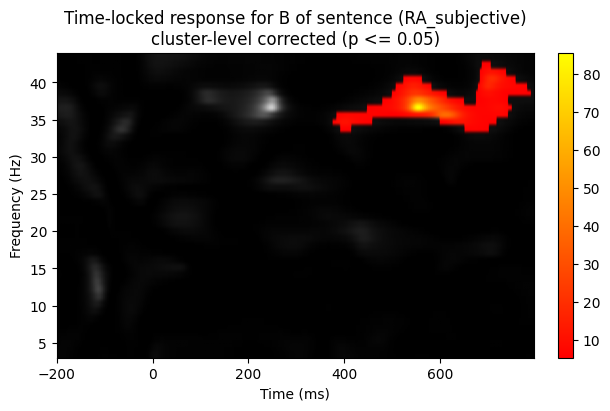

In [71]:
input_path = os.path.join(os.getcwd(), 'epochs')
filename = 'Own-experiment_group3_epochs_subject_rating-epo.fif'

epochs = mne.read_epochs(os.path.join(input_path, filename), preload=True)
epochs_new = epochs['action', 'sentence']

epochs_new_action = epochs_new["action"]
epochs_new_action

epochs_new_sentence= epochs_new["sentence"]
epochs_new_sentence

event_id_new = {'action/s_coherent/m_coherent': 1,
'sentence/s_coherent/m_coherent': 2,
'action/s_coherent/m_incoherent': 3,
'sentence/s_coherent/m_incoherent': 4,
'action/s_incoherent/m_coherent': 5,
'sentence/s_incoherent/m_coherent': 6,
'action/s_incoherent/m_incoherent': 7,
'sentence/s_incoherent/m_incoherent': 8}

event_id_new_action = {'action/s_coherent/m_coherent': 1,
'action/s_coherent/m_incoherent': 3,
'action/s_incoherent/m_coherent': 5,
'action/s_incoherent/m_incoherent': 7}

event_id_new_sentence = {'sentence/s_coherent/m_coherent': 2,
'sentence/s_coherent/m_incoherent': 4,
'sentence/s_incoherent/m_coherent': 6,
'sentence/s_incoherent/m_incoherent': 8}

epochs_new.equalize_event_counts(event_id_new)
epochs_new_action.equalize_event_counts(event_id_new_action)
epochs_new_sentence.equalize_event_counts(event_id_new_sentence)

##################
analysis_anova(epochs_new_sentence, event_id_new_sentence, RA, "RA_subjective", 1, "sentence", "B")

## Topography plot

Reading /work/EEG/CogNeuro2025/EEG_LAB/epochs/Own-experiment_group3_epochs-epo_2.fif ...
    Found the data of interest:
        t =    -200.00 ...     796.00 ms
        0 CTF compensation matrices available
Not setting metadata
878 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs before plotting...


/tmp/ipykernel_39092/450413719.py:4: RuntimeWarning: This filename (/work/EEG/CogNeuro2025/EEG_LAB/epochs/Own-experiment_group3_epochs-epo_2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(os.path.join(input_path, filename), preload=True)


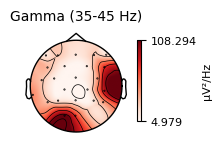

Averaging across epochs before plotting...


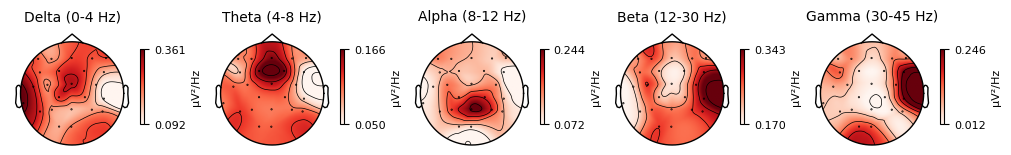

In [24]:
# Overview of topography

input_path = os.path.join(os.getcwd(), 'epochs')
filename = 'Own-experiment_group3_epochs-epo_2.fif' # based on participant

epochs = mne.read_epochs(os.path.join(input_path, filename), preload=True)
epochs_new = epochs['action', 'sentence']

spectrum = epochs_new["sentence"].compute_psd()

bands = {"Gamma (35-45 Hz)": (35, 45)}
spectrum.plot_topomap(bands=bands); # only for gamma

spectrum.plot_topomap(normalize=True); # for all

Reading /work/EEG/CogNeuro2025/EEG_LAB/epochs/Own-experiment_group3_epochs-epo_2.fif ...
    Found the data of interest:
        t =    -200.00 ...     796.00 ms
        0 CTF compensation matrices available
Not setting metadata
878 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_39092/2267652757.py:5: RuntimeWarning: This filename (/work/EEG/CogNeuro2025/EEG_LAB/epochs/Own-experiment_group3_epochs-epo_2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(os.path.join(input_path, filename), preload=True)


Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs before plotting...


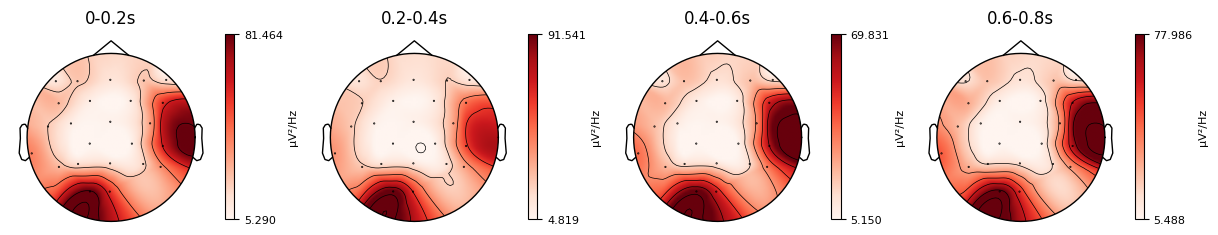

In [52]:
# For time segments separately only for gamma

input_path = os.path.join(os.getcwd(), 'epochs')
filename = 'Own-experiment_group3_epochs-epo_2.fif'

# Load and subset epochs
epochs = mne.read_epochs(os.path.join(input_path, filename), preload=True)
epochs_new = epochs['action', 'sentence']

# Define time windows
time_windows = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8)]

# Define band
bands = {"Gamma (35-45 Hz)": (35, 45)}

# Create one figure with multiple topomaps
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, len(time_windows), figsize=(15, 4))

for ax, (tmin, tmax) in zip(axes, time_windows):
    spectrum = epochs_new["sentence"].compute_psd(tmin=tmin, tmax=tmax)
    spectrum.plot_topomap(bands=bands, axes=ax, show=False)
    ax.set_title(f'{tmin}-{tmax}s')

## Average Power Time Plot

In [3]:
# taken from this repo https://github.com/laurabpaulsen/EEG_and_mouse_tracking/tree/main in time_frequency.ipynb and helper_functions.py

def average_power_time(power, channel_indices, freq_indices_b, freq_indices_a, time_indicies_b, time_indicies_a):
    '''
    returns the averaged power over channels and frequencies for each time point. 

    args:
        power: 
        channel_indices: the channels wanted
        freq_indices_b: the lowest frequency index wanted
        freq_indices_e: the highest frequency index wanted
        time_indices_b: the lowest time index wanted
        time_indices_e: the highest time index wanted
    '''

    ## getting the channels wanted and the wanted frequencies
    data = power.data[:, np.array(channel_indices), freq_indices_b:freq_indices_a, time_indicies_b:time_indicies_a]

    ## averaging over the epochs
    average_epo = np.mean(data, axis = 0)

    ## averaging over the channels
    average = np.mean(average_epo, axis = 0)

    ## averaging over frequencies
    average = np.mean(average, axis = 0)
 
    return average

In [14]:
input_path = os.path.join(os.getcwd(), 'epochs')
filename = 'Own-experiment_group3_epochs-epo.fif'  # change for participants
epochs = mne.read_epochs(os.path.join(input_path, filename), preload=True)

freqs = np.arange(3, 45, 1)
n_cycles = freqs / 3.  # different number of cycle per frequency

action_coh =  epochs["action/s_coherent"].compute_tfr(method = "morlet", freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=False, decim=1, n_jobs=1)
action_incoh =  epochs["action/s_incoherent"].compute_tfr(method = "morlet", freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=False, decim=1, n_jobs=1)
sentence_coh =  epochs["sentence/s_coherent"].compute_tfr(method = "morlet", freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=False, decim=1, n_jobs=1)
sentence_incoh =  epochs["sentence/s_incoherent"].compute_tfr(method = "morlet", freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=False, decim=1, n_jobs=1)


Reading /work/EEG/CogNeuro2025/EEG_LAB/epochs/Own-experiment_group3_epochs-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     796.00 ms
        0 CTF compensation matrices available
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated


In [86]:
# this is how we went from channel names to channel indices 
mne.pick_channels(epochs.info['ch_names'], include = ["F4", "FC6", "FC2", "F8"])

array([ 5, 10,  9,  6])

In [19]:
# frequencies are -3 because of our freqs which goes from 3 instead of 1
freq_ind_b = 32
freq_ind_a = 43
# time found out by trial and error (based on what we used for time) 
time_ind_b = 50
time_ind_a = 300

#LA = ["F7", "F3", "FC5", "FC1"]
#RA = ["F4", "FC6", "FC2", "F8"]
#LP = ["P3", "P7", "CP1", "TP9"]
#RP = ["P4", "CP2", "CP6", "P8"]

# the numbers here are -6 because we have 6 bad channels which were excluded but the indices above have not been affected
RA = [3, 8, 7, 4]
RP = [20, 15, 16, 21]
LA = [0, 1, 5, 6]
LP = [18, 17, 14, 13]  

## averaging over gamma frequencies for RA region
average_action_coh = average_power_time(action_coh, RA, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)
average_action_incoh = average_power_time(action_incoh, RA, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)
average_sentence_coh = average_power_time(sentence_coh, RA, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)
average_sentence_incoh = average_power_time(sentence_incoh, RA, freq_ind_b, freq_ind_a, time_ind_b, time_ind_a)

In [20]:
# this is how we went from channel names to channel indices, by having it print
times = action_coh.times[time_ind_b:time_ind_a]
# print(times)

Text(0.5, 0.98, 'Average Power R 35-45 Hz')

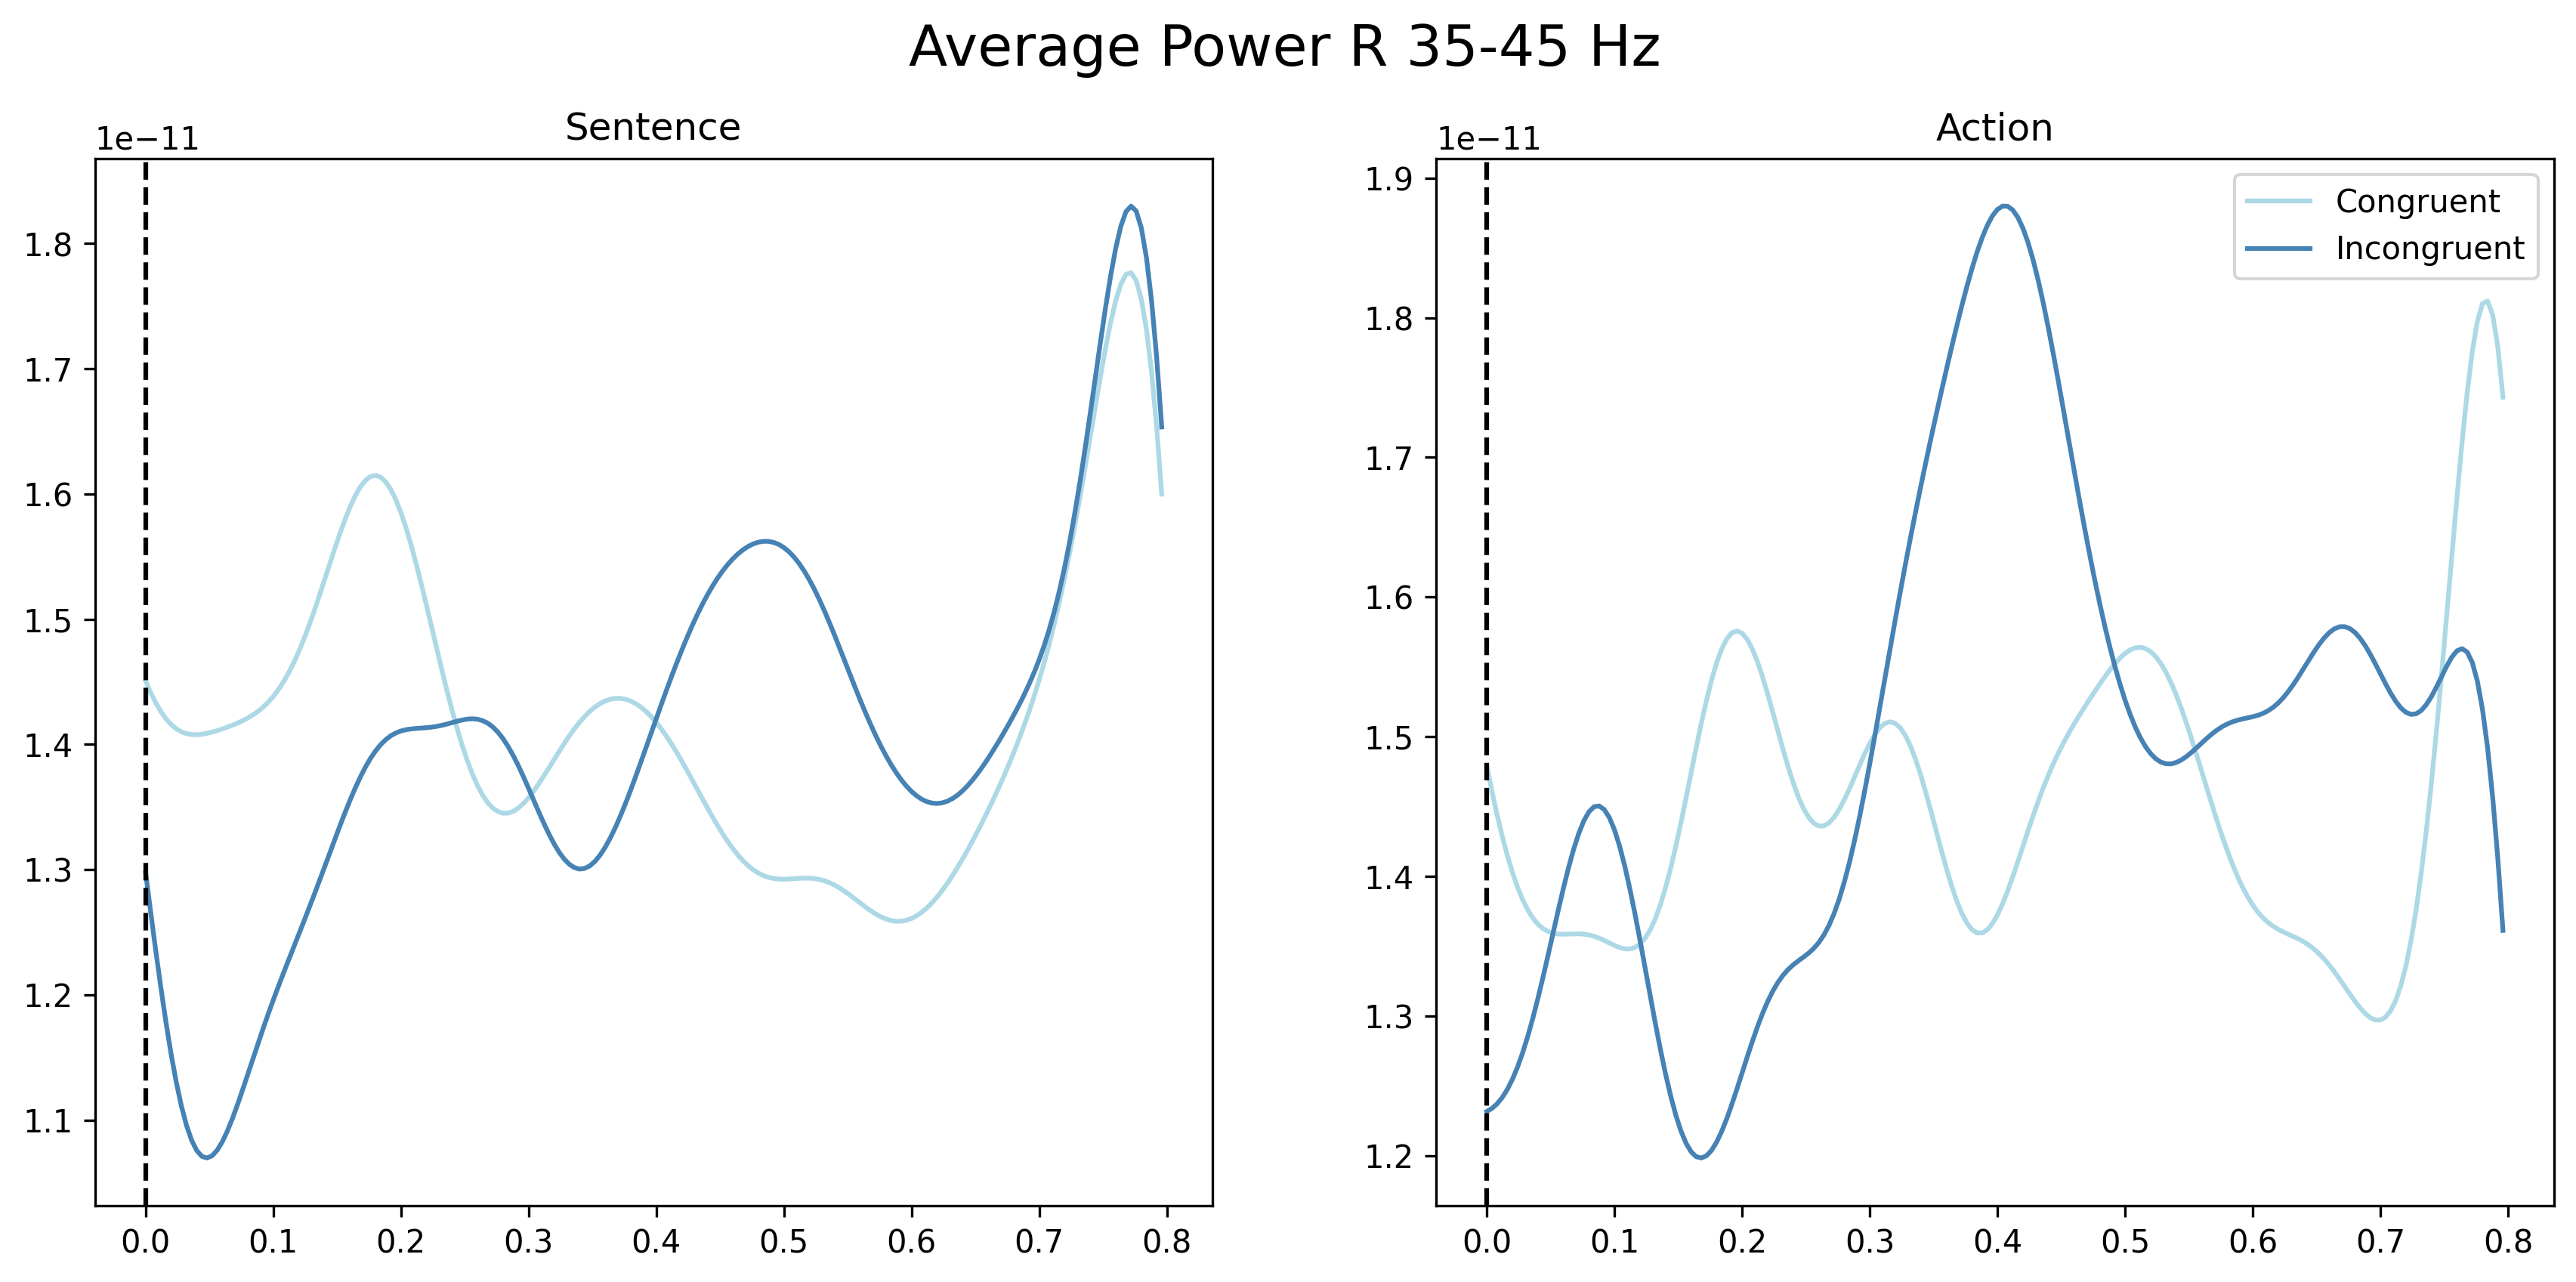

In [21]:
# plotting it

fig, axis = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axis[0].plot(times, average_sentence_coh, 'lightblue', label = 'Congruent')
axis[0].plot(times, average_sentence_incoh, 'steelblue', label = 'Incongruent')
axis[0].axvline(x=0.0, color='black', linestyle='--')
axis[0].title.set_text('Sentence')

axis[1].plot(times, average_action_coh, 'lightblue', label = 'Congruent')
axis[1].plot(times, average_action_incoh, 'steelblue', label = 'Incongruent')
axis[1].title.set_text('Action')
axis[1].axvline(x=0.0, color='black', linestyle='--')
axis[1].legend(loc = 'upper right')

fig.suptitle('Average Power R 35-45 Hz', fontsize=18)